# Project II: Economic Growth 

This notebook will help you getting started with analyzing the growth dataset, `growth.csv`.

The code cell below has to be run to use the missingno package.

In [ ]:
#pip install missingno

In [16]:
import pandas as pd 
import numpy as np 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns 
import missingno as msno
from scipy.stats import norm
from sklearn.linear_model import Lasso

## Read data 

In [2]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary
print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


# Collections of variables

In order to make the analysis simpler, it may be convenient to collect variables in sets that belong together naturally. 

In [110]:
# all available variables
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage']
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources,
          'education':vv_educ
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]


In [111]:
# convenient to keep a column of ones in the dataset
dat['constant'] = np.ones((dat.shape[0],))

# Pre-selection of variables 

First, we subset the data to only contain the non-missing observations for gdp_initial and gdp_growth. This makes it easier to see which variables have many observations where it really matters.

In [7]:
I = dat[['gdp_growth', 'lgdp_initial']].notnull().all(axis=1)
dat_sub = dat.loc[I,:].copy()

Now plot number of observations for each category

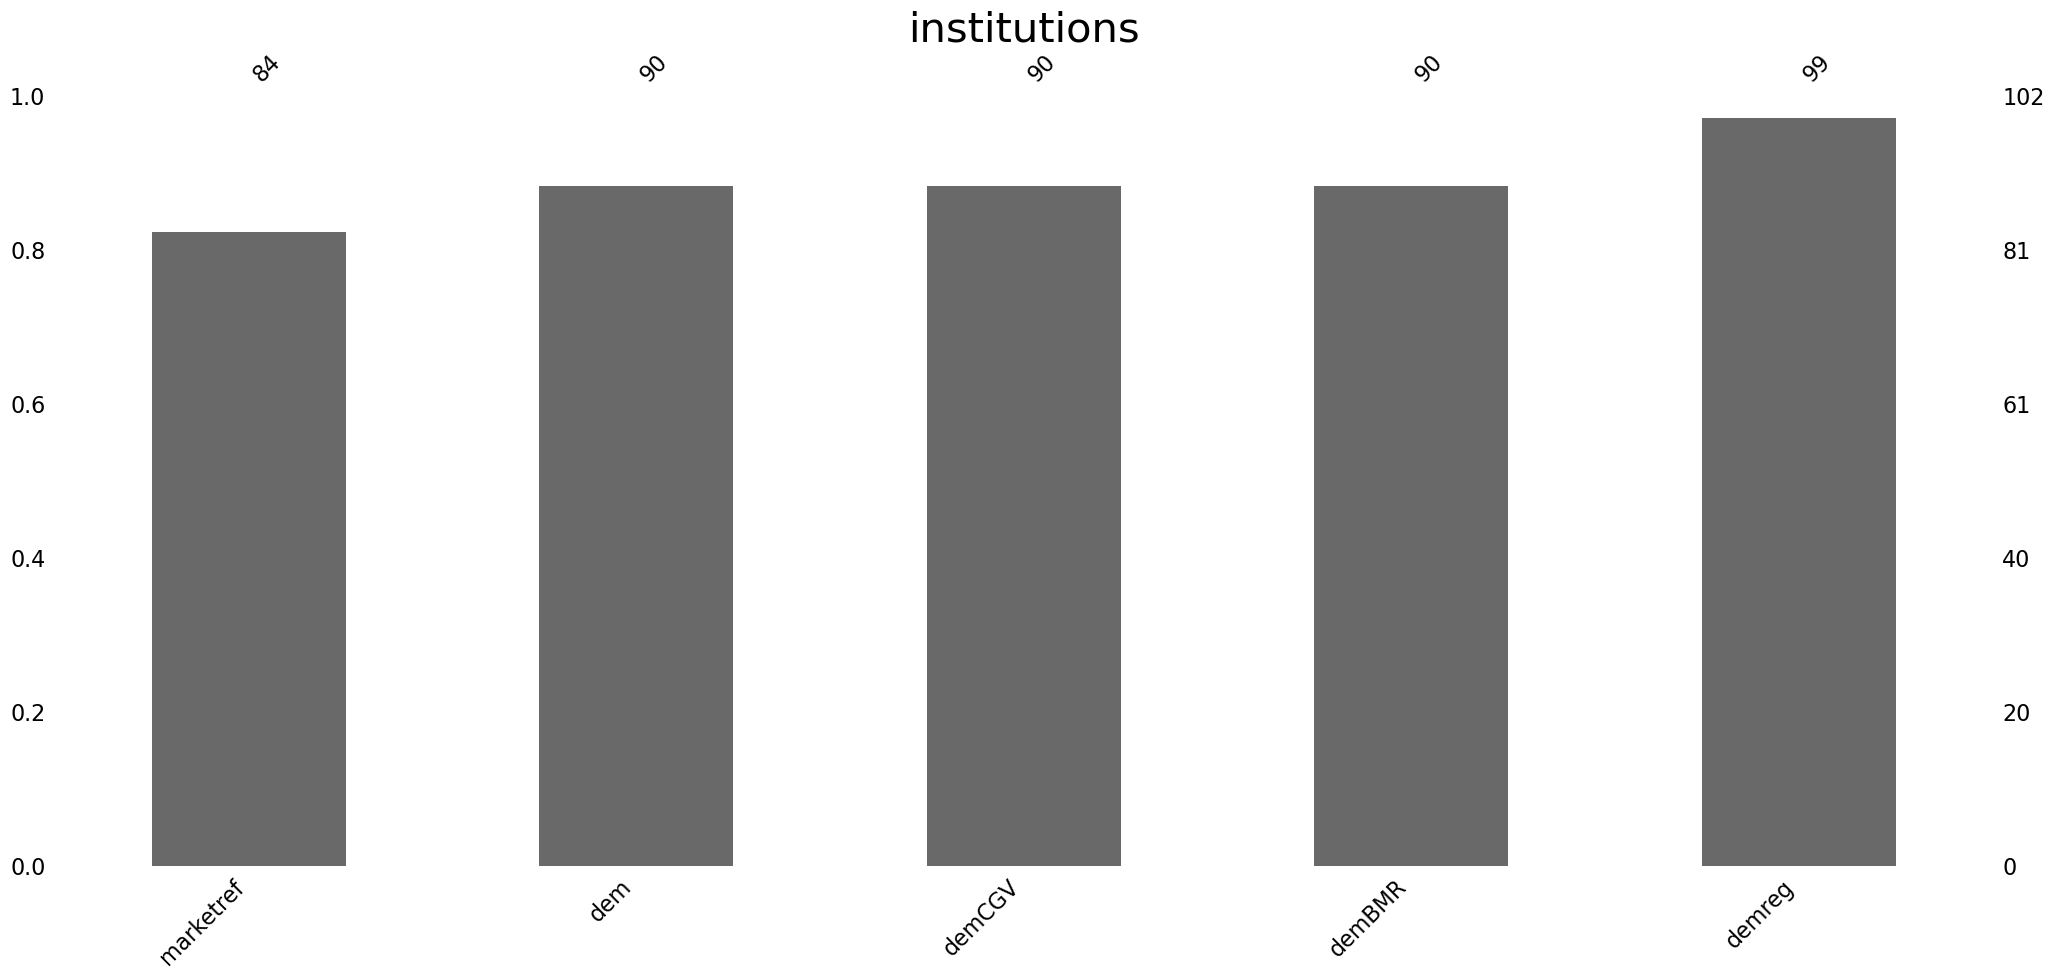

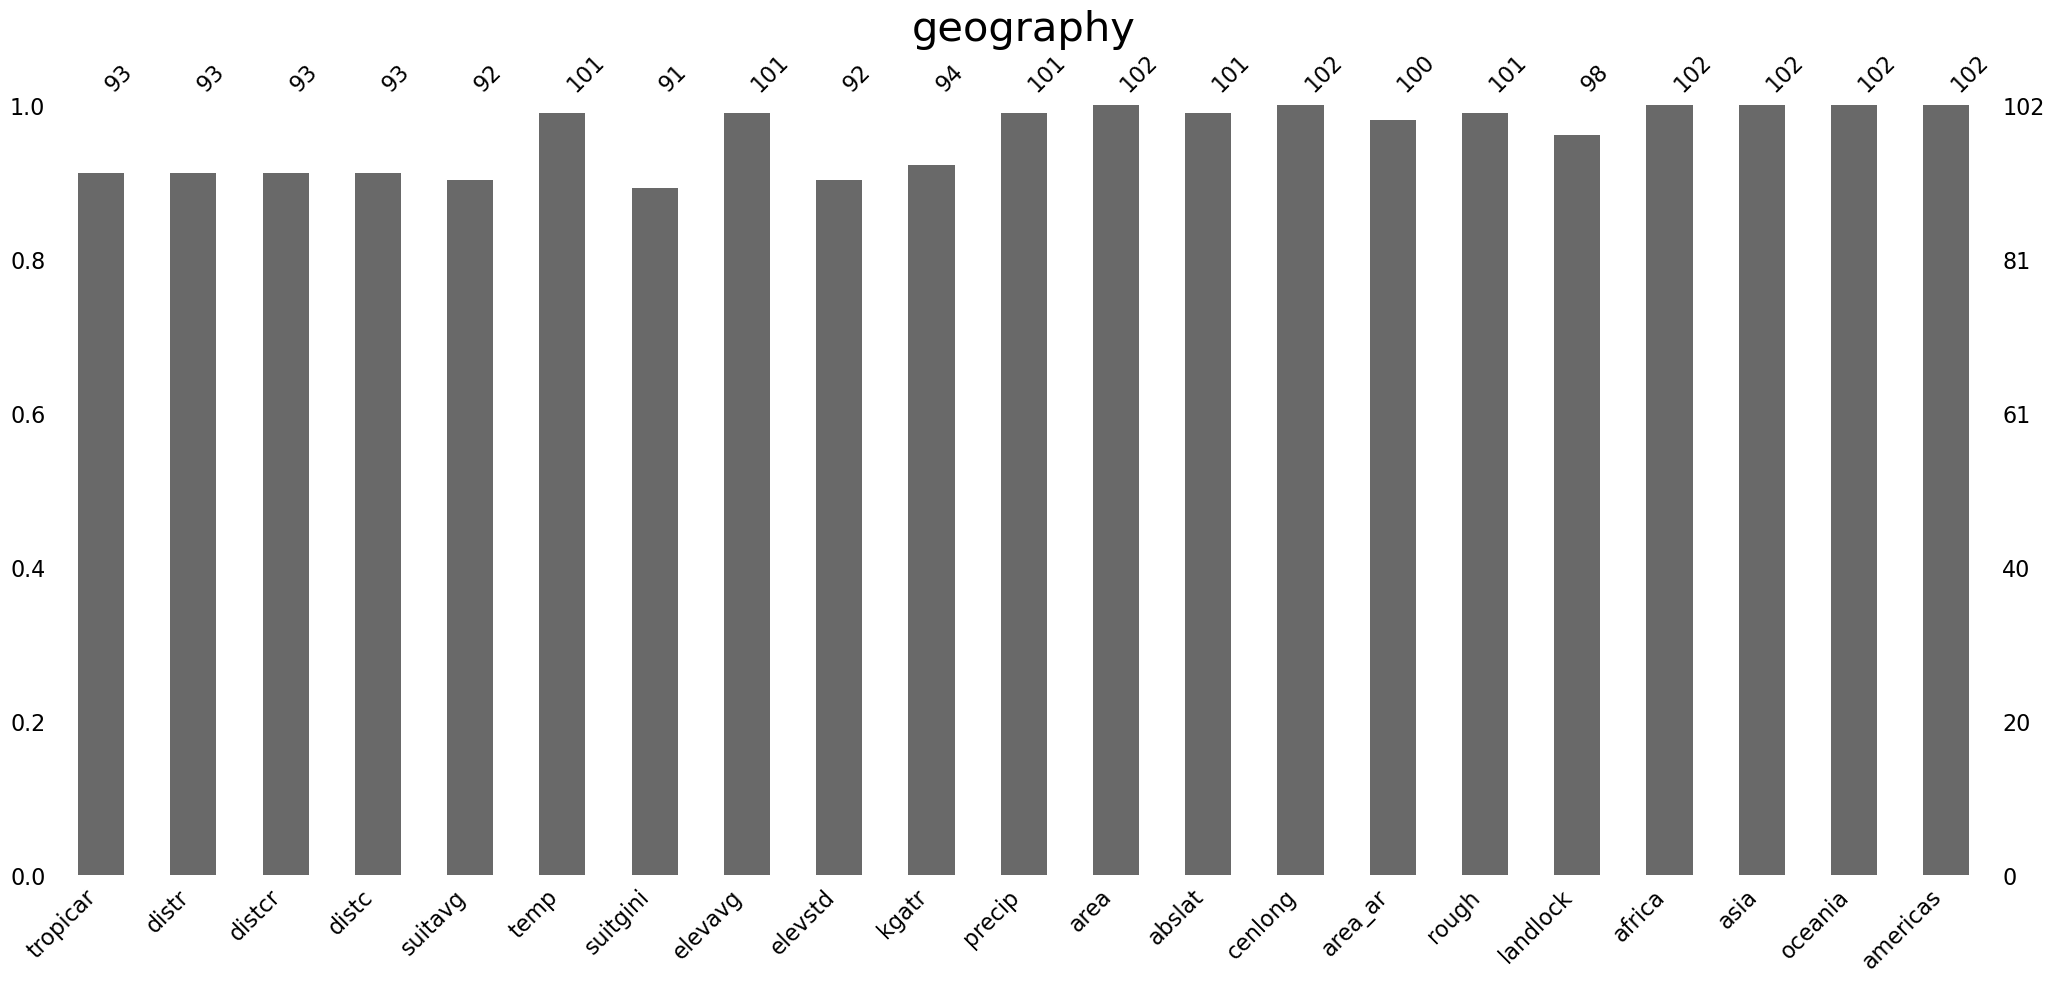

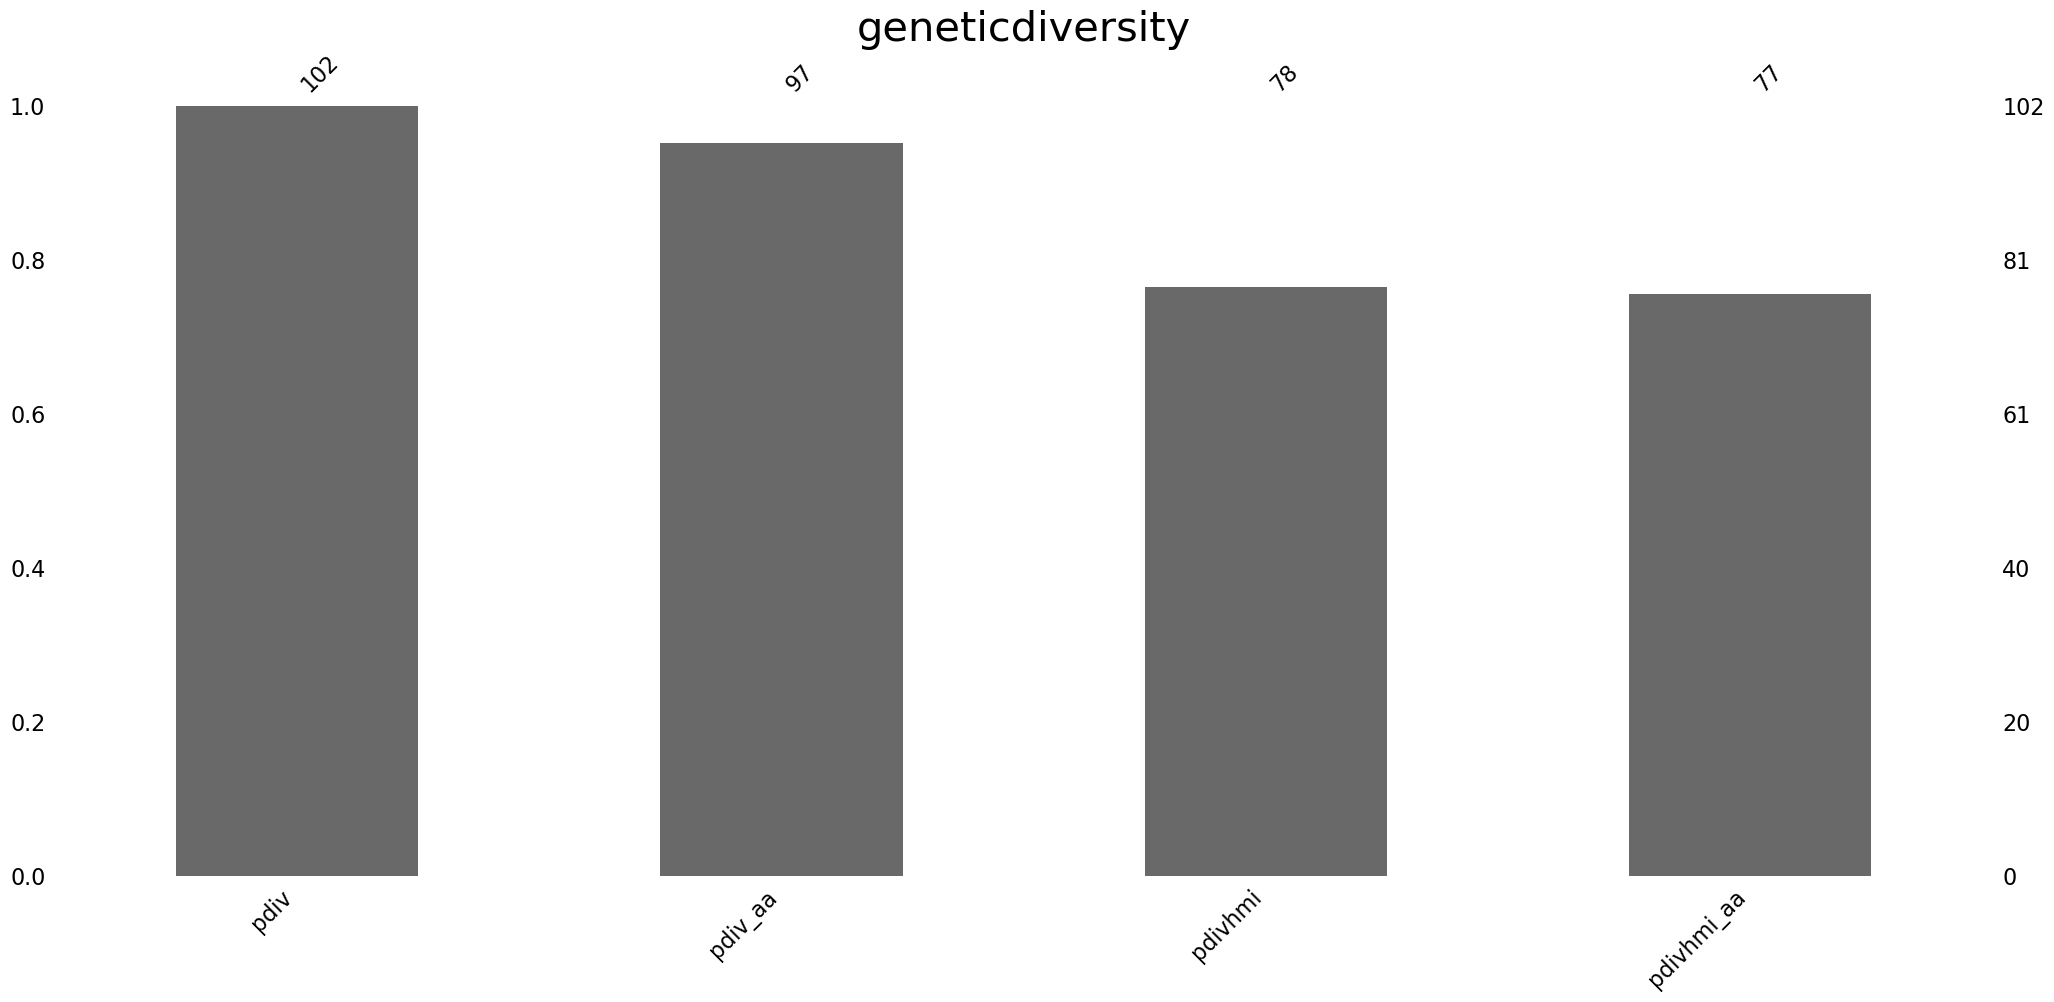

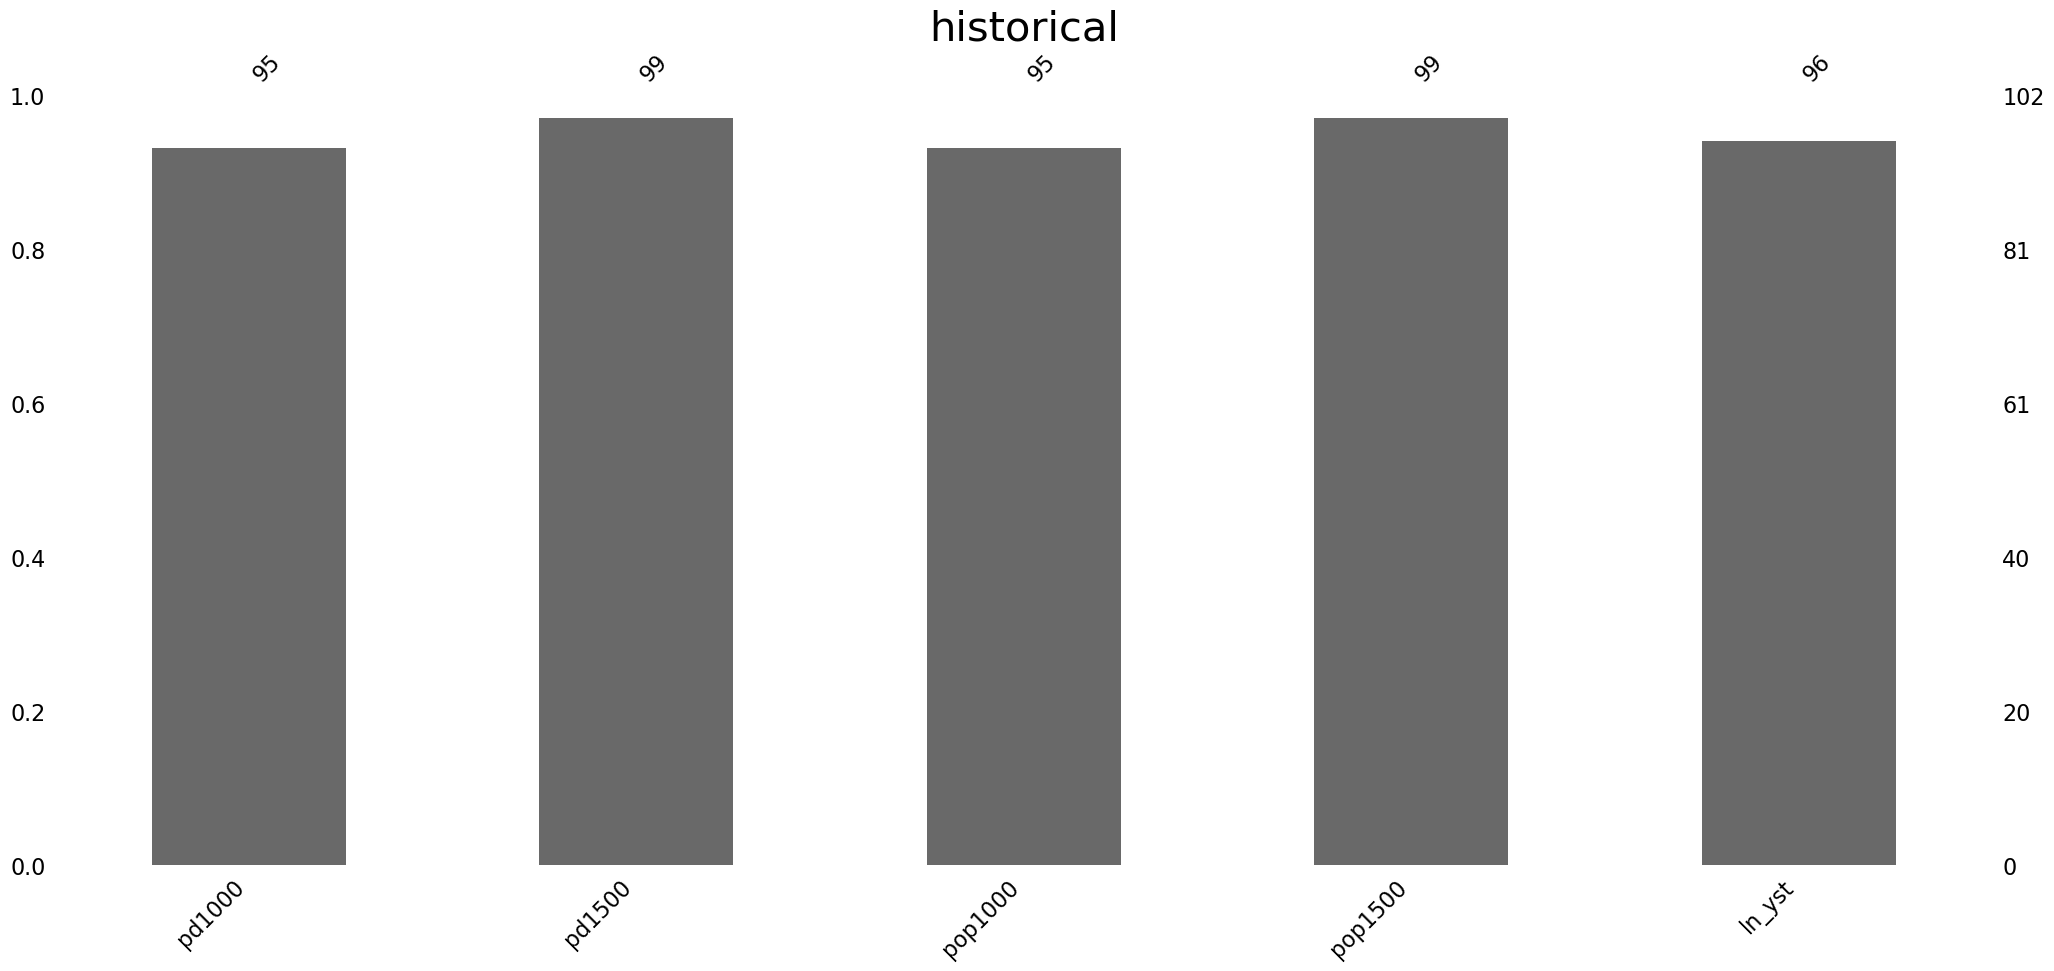

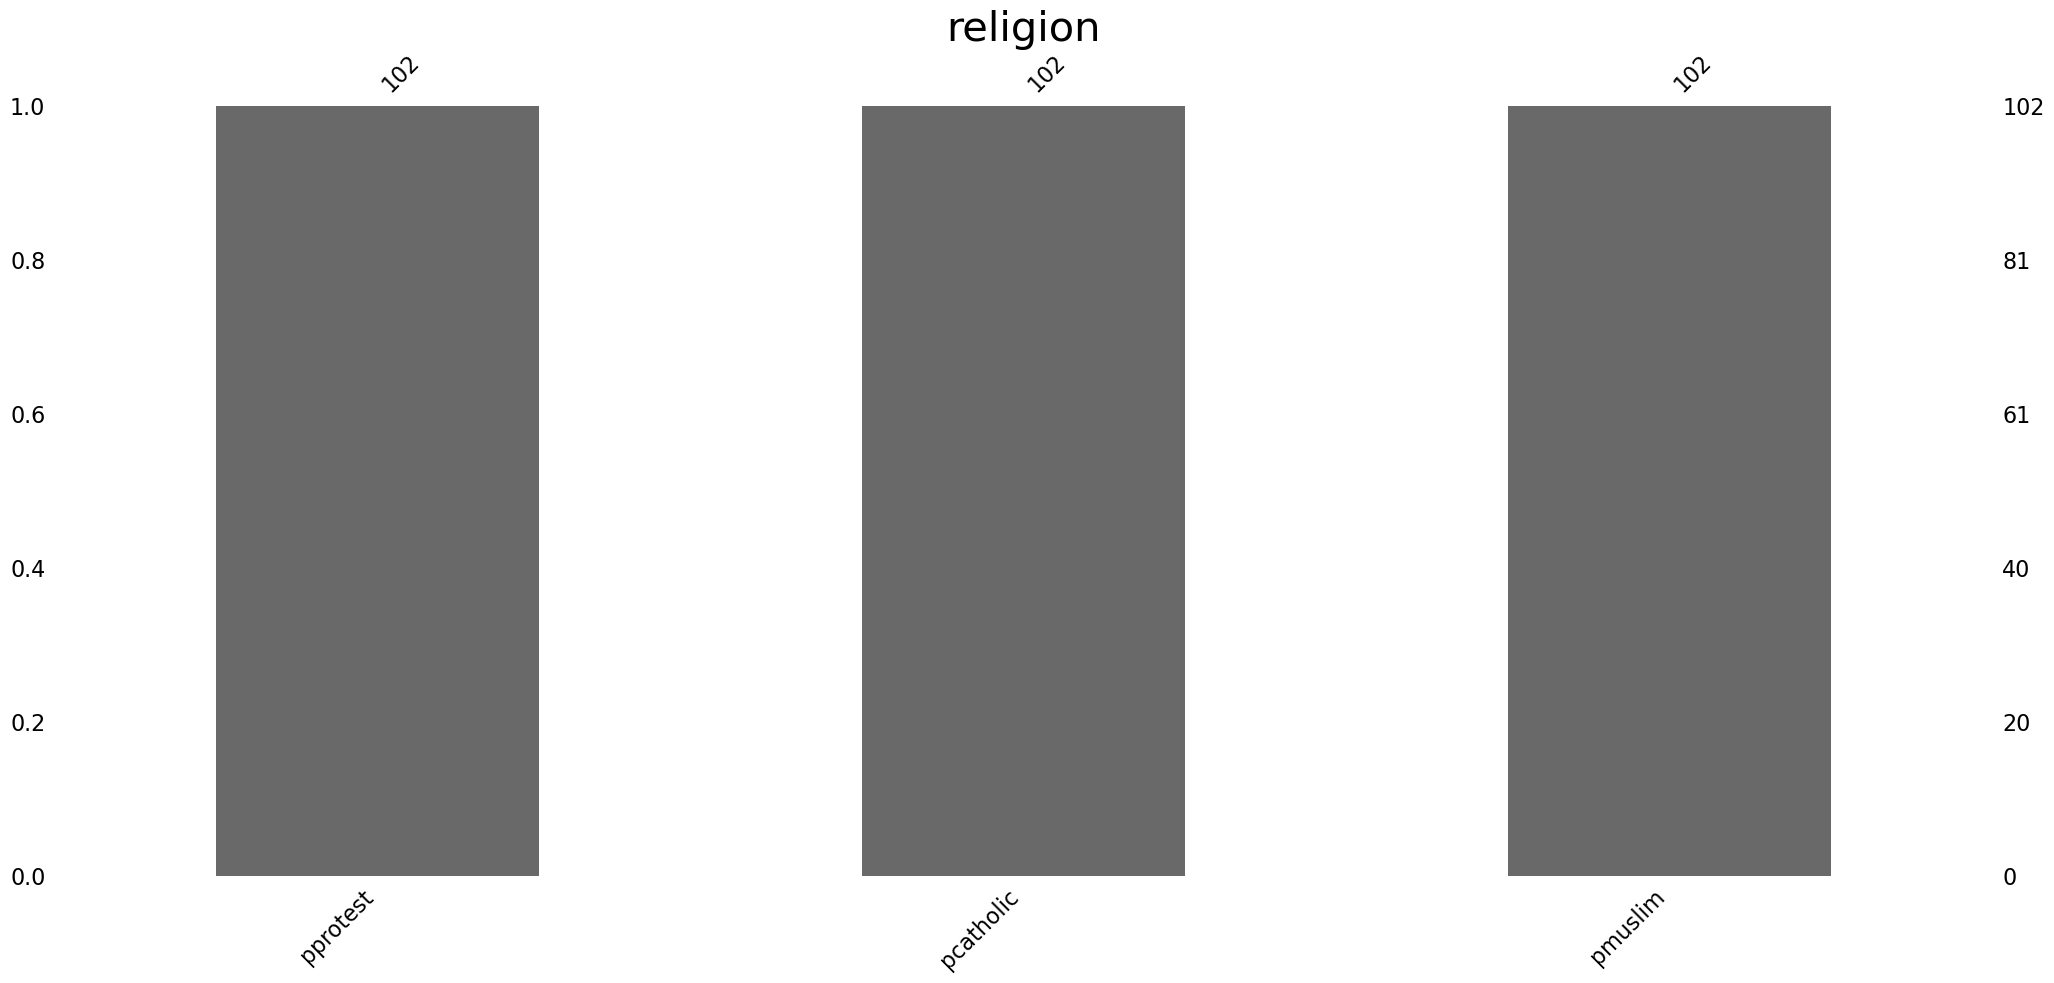

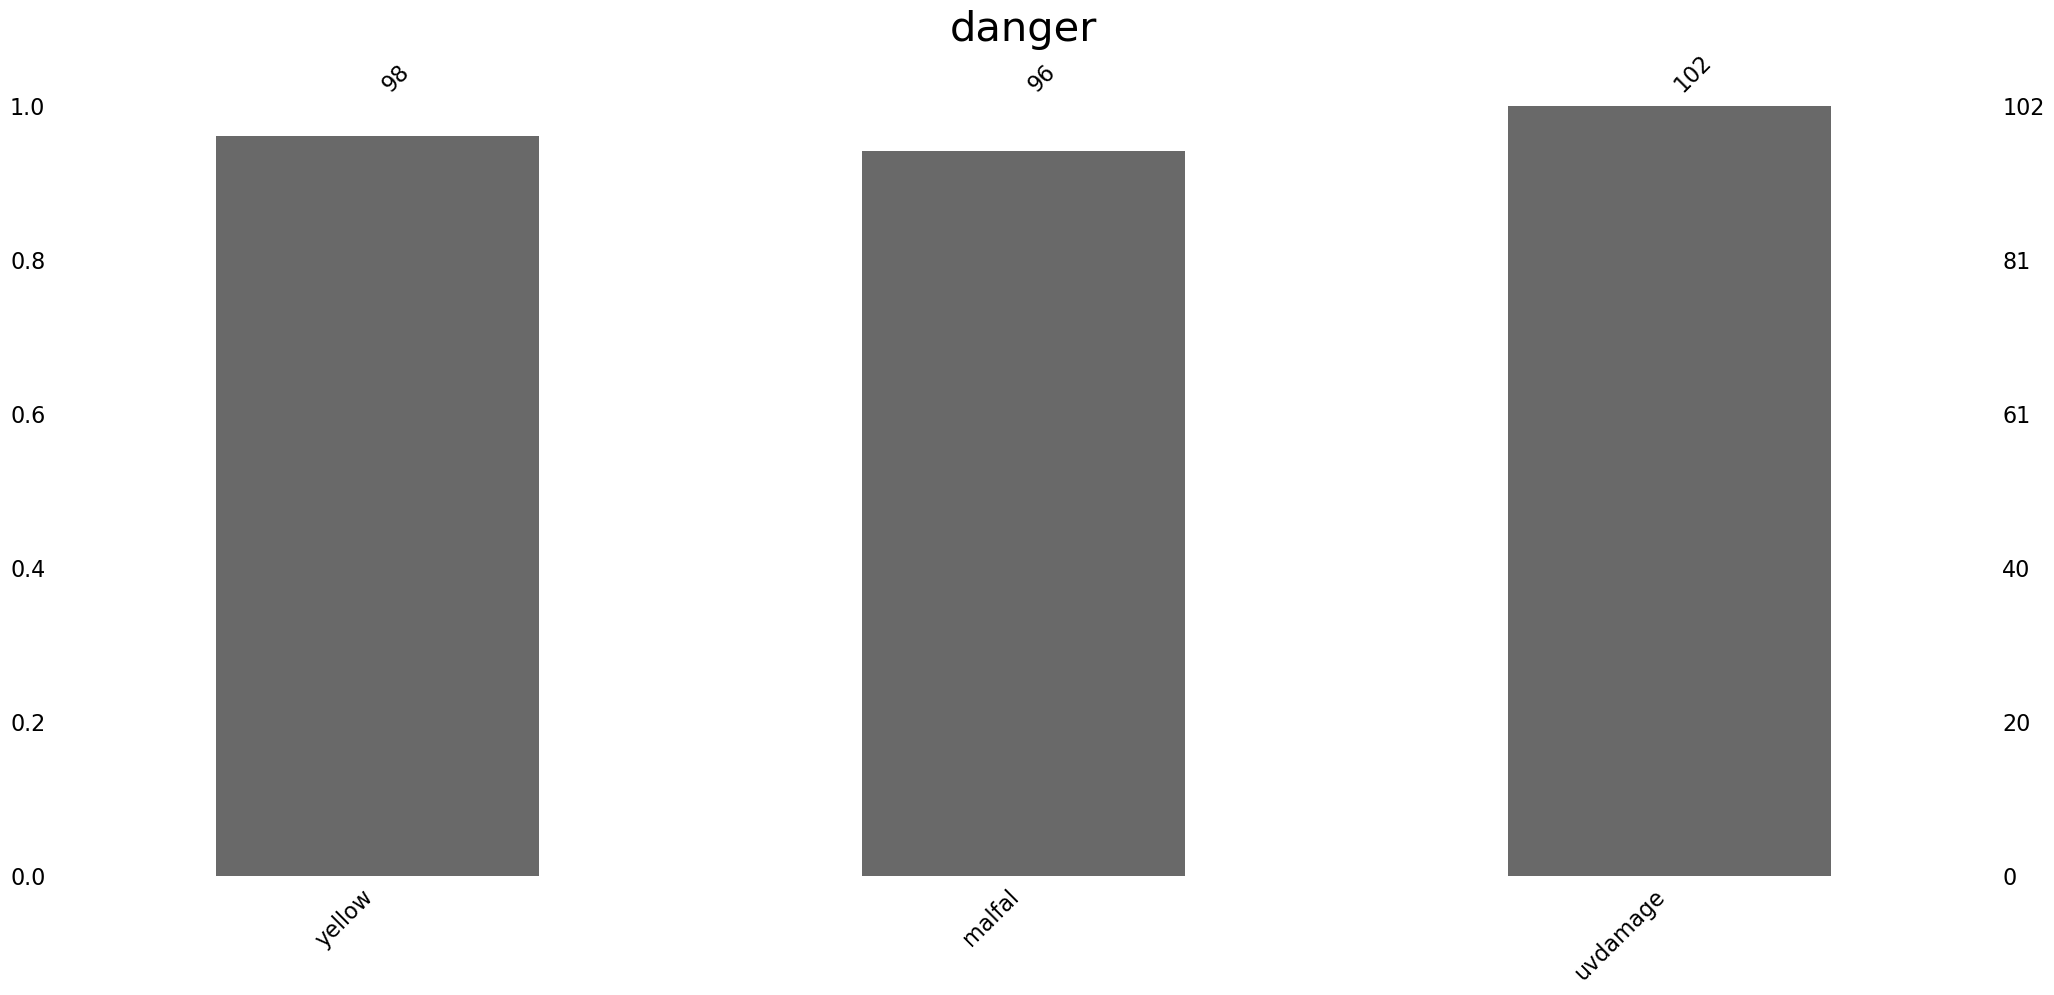

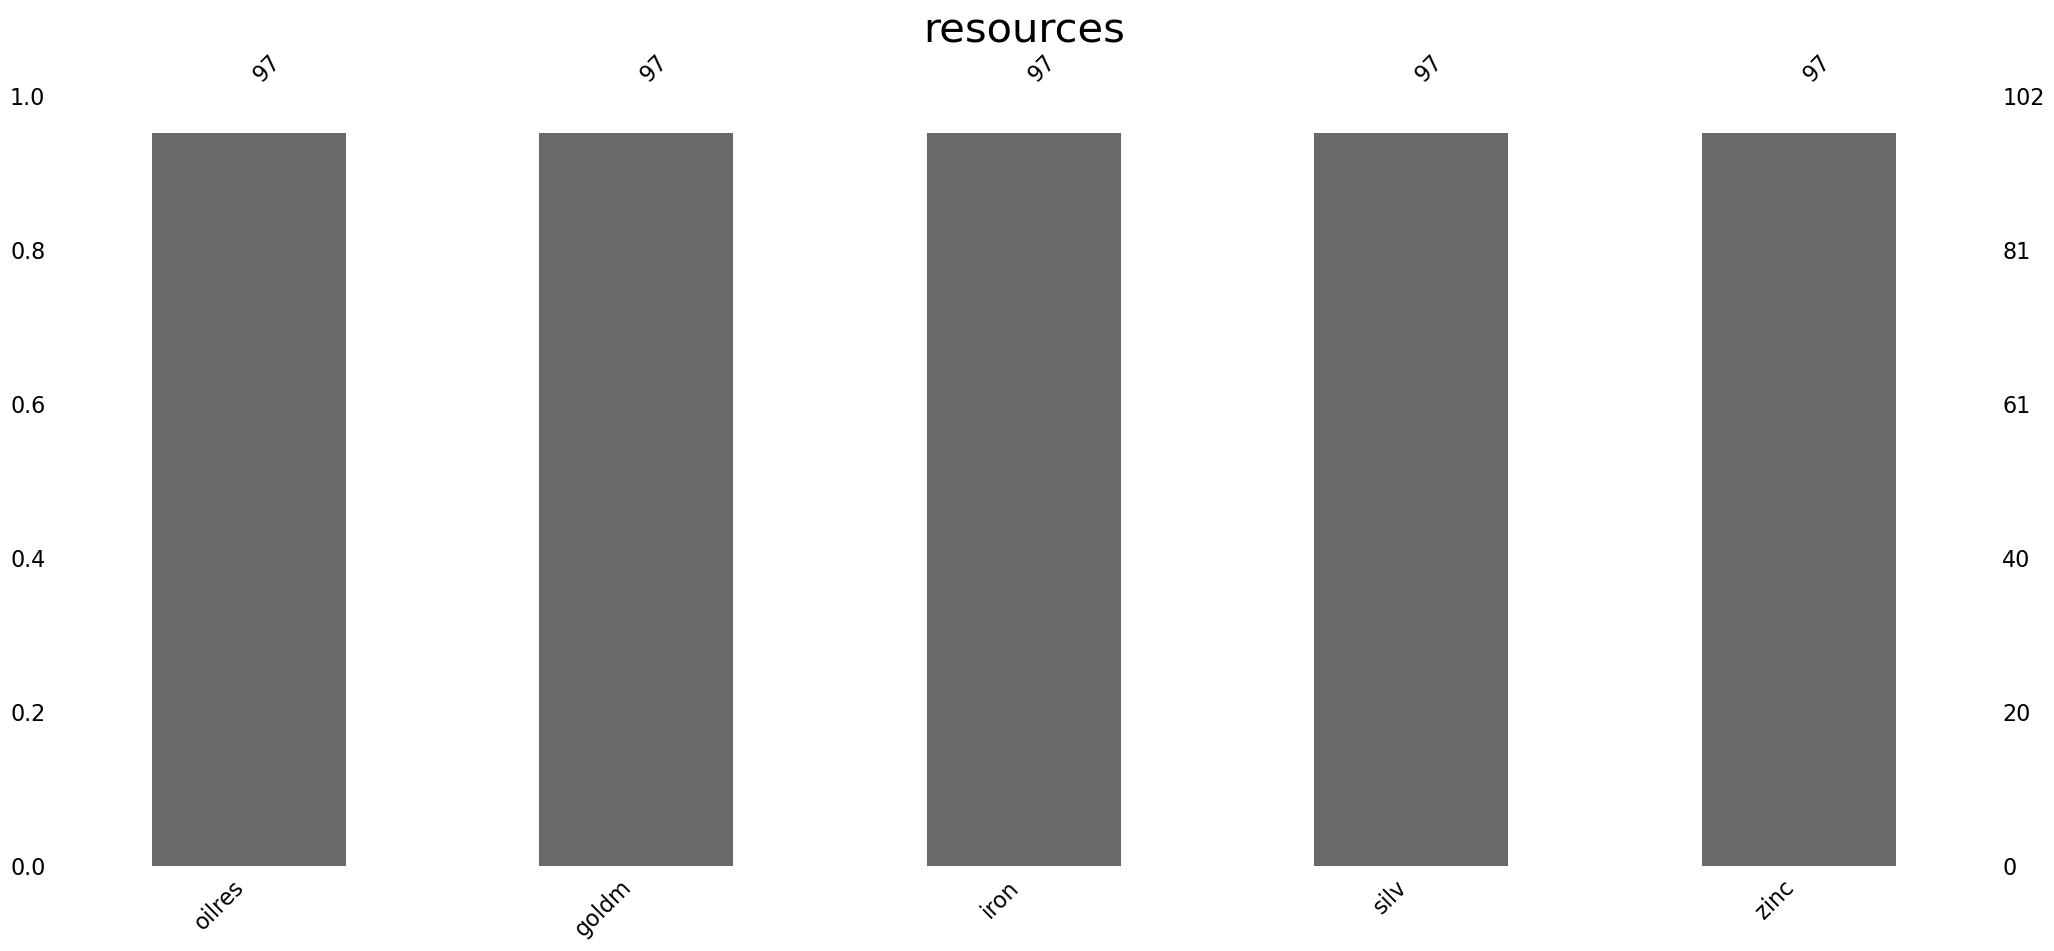

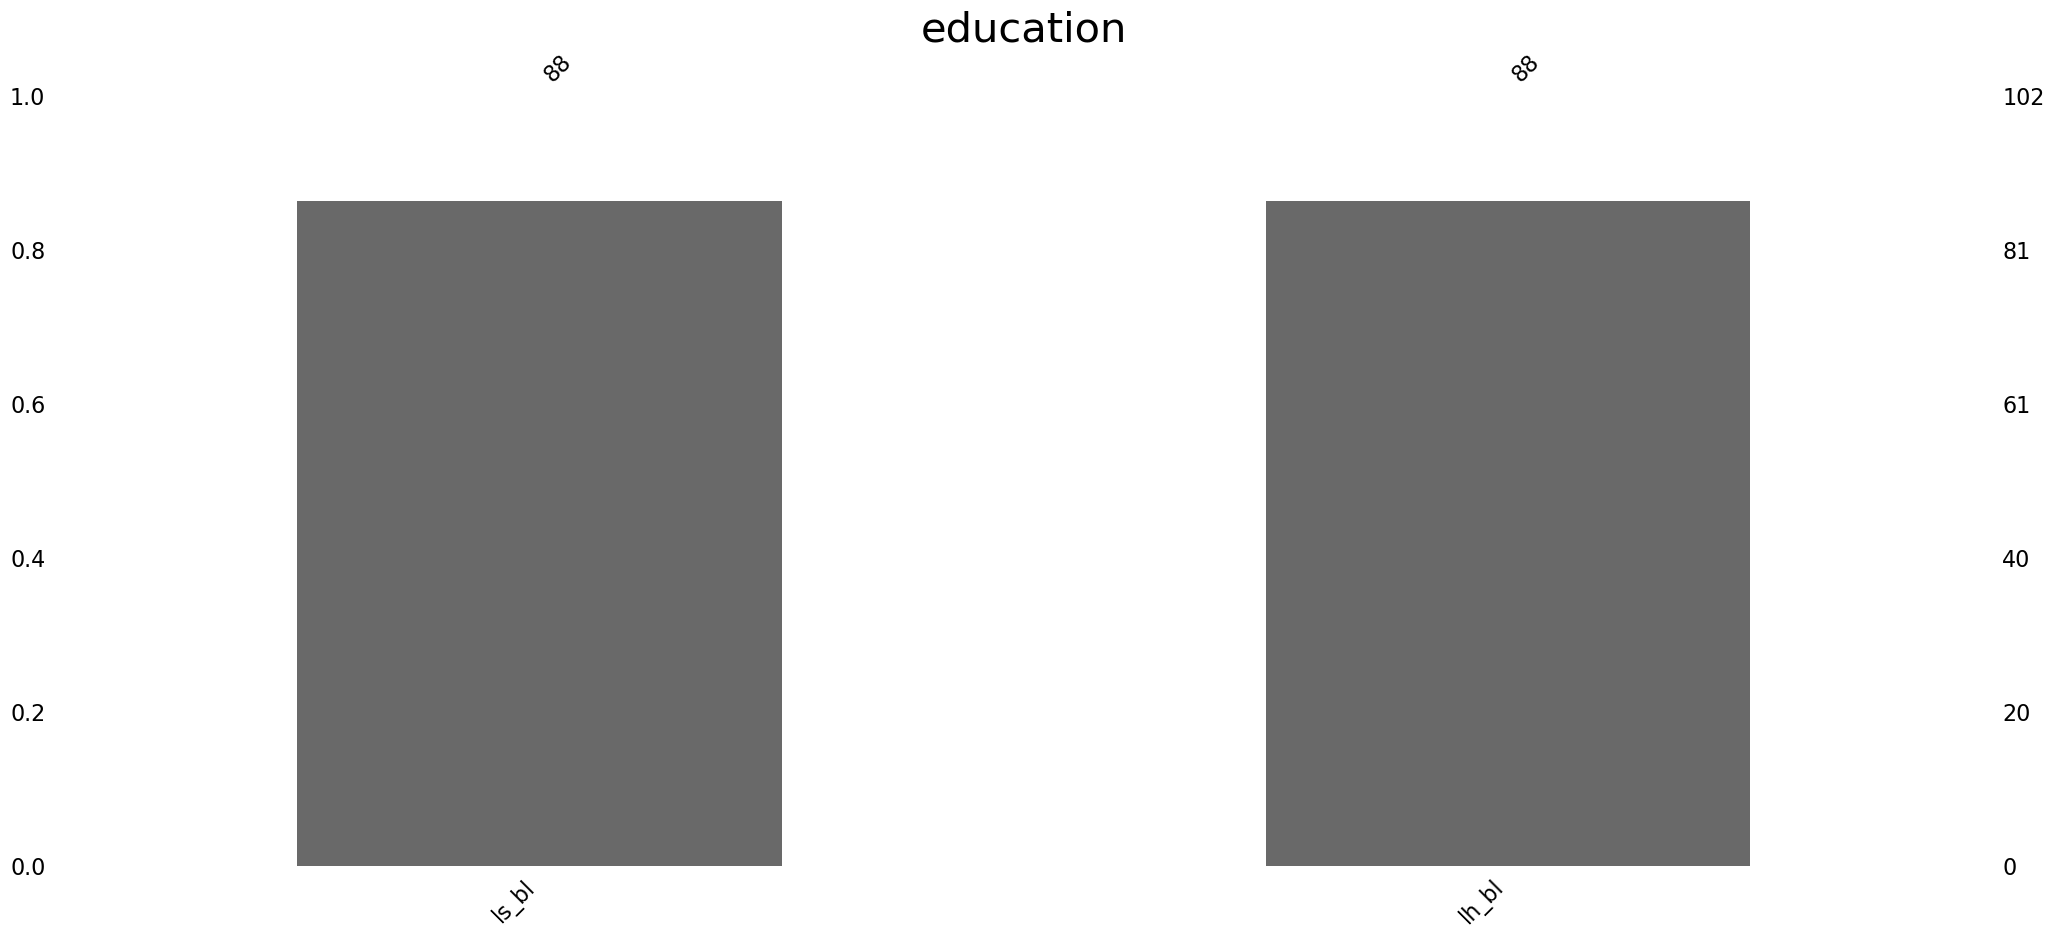

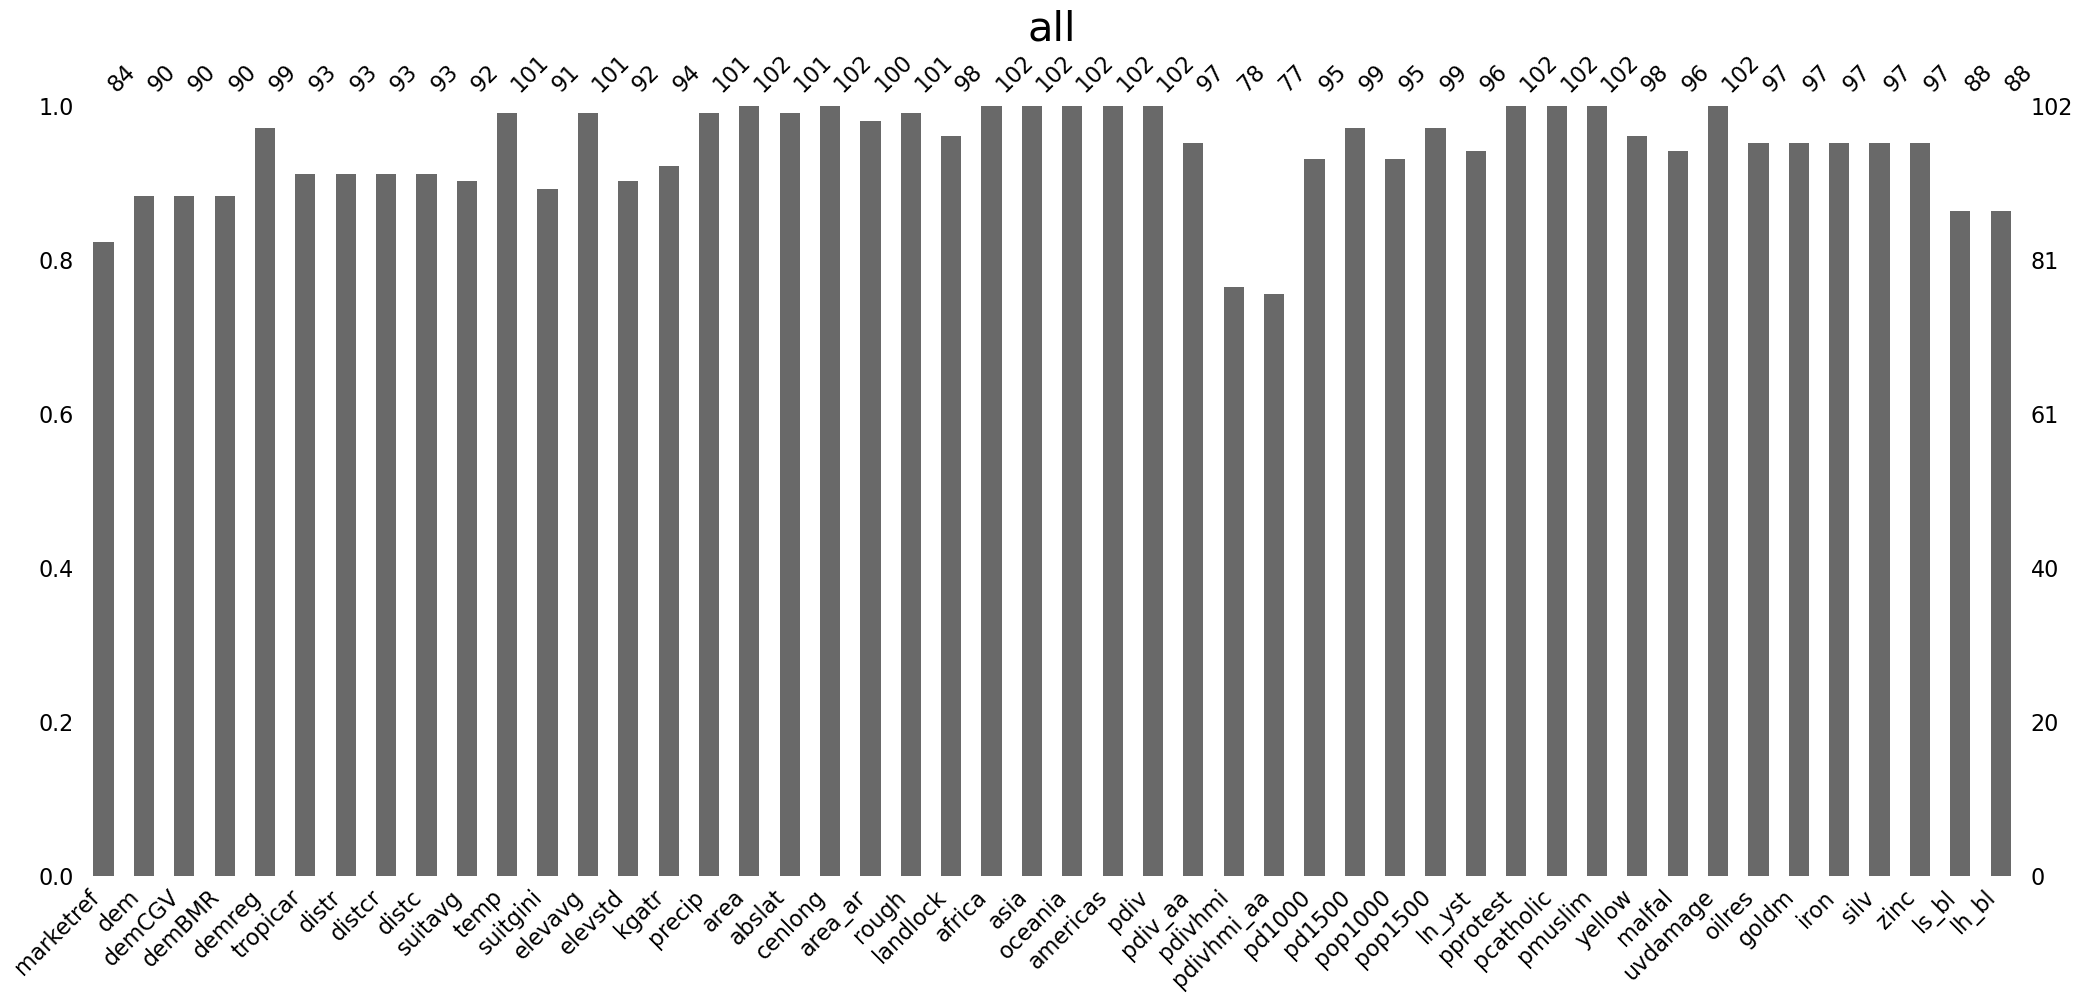

In [114]:
for key in vv_all:
    plt.figure()
    msno.bar(dat_sub[vv_all[key]])
    plt.title(key, fontsize=30)
    plt.show()

In [125]:
test = vv_educ+vv_resources+vv_danger+vv_religion+vv_historical+['pdiv']+['demreg']+['africa']+['asia']+['oceania']+['americas']
test2 = ['pdiv']+['demreg']+['africa']+['asia']+['oceania']+['americas']

Now we set up y, d, Z and X

In [132]:
vs = test2 #skal rettes til
zs = ['pop_growth', 'investment_rate'] + vs
xs = ['lgdp_initial'] + zs #our target is index

# avoiding missings
all_vars = ['gdp_growth'] + xs
I = dat[all_vars].notnull().all(1)

# extract data
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%
d = dat.loc[I, 'lgdp_initial'].values.reshape((-1,1))
Z = dat.loc[I, zs].values
X = dat.loc[I, xs].values


Find number of observations

In [134]:
print(f'Number of observations: {y.shape[0]}')

Number of observations: 96


# OLS

In [127]:
# add const. (unless this breaks the rank condition)
oo = np.ones((I.sum(),1))
X_ols = np.hstack([X, oo])
xs_ols = xs + ['constant'] # we put it in as the last element

# check the rank condition
K = X_ols.shape[1]
assert np.linalg.matrix_rank(X_ols) == X_ols.shape[1], f'X does not have full rank'

# compute the OLS estimator
betas = np.linalg.inv(X_ols.T @ X_ols) @ X_ols.T @ y

AttributeError: 'list' object has no attribute 'shape'

In [109]:
# format nicely
print(f'Mean y = {y.mean(): 5.2f}% growth per year')
print(f'beta= {betas[0,0]: 5.3f} (log GDP initial)')

Mean y =  1.51% growth per year
beta= -1.053 (log GDP initial)


# Post-double Lasso

Standardize

In [36]:
def standardize(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    X_stan = (X - mu)/sigma
    return X_stan


# Standardize data
X_stan = standardize(X)
Z_stan = standardize(Z)
d_stan = standardize(d)

Check shape

In [13]:
print(f"y.shape = {y.shape}, X_stan.shape = {X_stan.shape}, Z_stan.shape = {Z_stan.shape}, d_stan.shape = {d_stan.shape}")


y.shape = (85, 1), X_stan.shape = (85, 30), Z_stan.shape = (85, 28), d_stan.shape = (85, 1)


Define function for BCCH penalty

In [37]:
def BCCH_penalty(x,y):
    # BCCH pilot penalty
    n,p = x.shape
    c = 1.1
    alpha = 0.05
    yx_scale = (np.max((x.T ** 2) @ ((y-np.mean(y)) ** 2) / n)) ** 0.5
    penalty_pilot = c / np.sqrt(n) * norm.ppf(1-alpha/(2*p)) * yx_scale

    # Pilot estimates
    #Create predicted value using Lasso 
    pred = Lasso(alpha=penalty_pilot).fit(x,y).predict(x)

    # Updated penalty
    eps = y - pred 
    eps_x_scale = (np.max((x.T ** 2) @ (eps ** 2) / n)) ** 0.5
    penalty = c*norm.ppf(1-alpha/(2*p))*eps_x_scale/np.sqrt(n)

    return penalty

Penalty for y on X

In [38]:
penalty_yX = BCCH_penalty(X_stan,y)

Now we run Lasso of Y on d and Z

In [42]:
#Run Lasso
fit_BCCH_yx = Lasso(alpha=penalty_yX, max_iter=10000).fit(X_stan,y)
coefs_y = fit_BCCH_yx.coef_

# Calculate residuals
res_yx = y - fit_BCCH_yx.predict(X_stan).reshape(-1,1)

# Calculate Y - Z@gamma (epsilon + alpha*d)
res_yz = y - Z_stan@np.array(coefs_y[1:]).reshape(-1,1)


Penalty for d on Z

In [43]:
penalty_dZ = BCCH_penalty(Z_stan,d)

Now running Lasso of d on Z

In [59]:
# Run Lasso
fit_BCCH_dz = Lasso(alpha=penalty_dZ,max_iter=10000).fit(Z_stan,d)
coefs_d=fit_BCCH_dz.coef_

# Calculate residuals
res_dz=d-fit_BCCH_dz.predict(Z_stan).reshape(-1,1)

Calculate alpha

In [78]:
# Calculate alpha
num = res_dz.T@res_yz
denom = res_dz.T@d
alpha_PDL = np.array(num/denom)[0][0]

# Display alpha
print("alpha_PDL = ",alpha_PDL.round(2))

alpha_PDL =  -0.14


Calculate implied variance estimate

In [63]:
N = X.shape[0]

In [64]:
# Calculate variance    
res_yx_sq = np.square(res_yx)
res_dz_sq = np.square(res_dz)

num = np.zeros((1,1))
for i in range(N):
    num += res_yx_sq[i]*res_dz_sq[i]
num = num/N

denom = (np.sum(res_dz_sq)/N)**2

sigma2_PDL=(num/denom)[0][0]

# Display variance
print("sigma2_PDL = ",sigma2_PDL.round(2))

sigma2_PDL =  1.3


And standard error

In [65]:
# Calculate standard error
se_PDL = np.sqrt(sigma2_PDL/N)

# Display standard error
print("se_PDL = ",se_PDL.round(2))

se_PDL =  0.12


Confidence interval

In [66]:
# Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(0.975)

# Calculate confidence interval
CI_low_PDL  = alpha_PDL-q*se_PDL
CI_high_PDL = alpha_PDL+q*se_PDL

# Display confidence interval
print("CI_PDL = ",(CI_low_PDL.round(2),CI_high_PDL.round(2)))

CI_PDL =  (-0.38, 0.11)
